In [232]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
device = '/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
device

'/GPU:0'

# Load Data

In [94]:
training_dataset_path = 'data/training_dataset.csv'
training_df = pd.read_csv(training_dataset_path)
print("Shape:", training_df.shape)

Shape: (8795, 55)


In [112]:
training_text = training_df['Title']
features = training_df.columns[1:]
training_labels = training_df[features]
num_classes = len(features)
print("Number of classes:", num_classes)

Number of classes: 54


# Transform

## Tokenize

In [98]:
# create indobert tokenizer instance
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
vocab_size = len(tokenizer.vocab.keys())
print("Number of vocabulary:", vocab_size)

Number of vocabulary: 30521


In [147]:
# tokenize the title
training_sequences = training_text.apply(lambda sequence: tokenizer.encode(sequence))
print("Real sentence:\n", training_text[4444])
print("Tokenized sentence:\n", training_sequences[4444])

Real sentence:
 tetap wewenang direktur jender anggar imbang uang direktur jender bendahara serta wewenang kepala kantor instansi vertik direktorat jender bendahara rangka laksana anggar dapat belanja negara tahun anggar
Tokenized sentence:
 [2, 830, 8517, 4726, 4796, 22931, 30359, 11907, 988, 4726, 4796, 14272, 501, 8517, 1179, 1571, 5288, 8858, 39, 9170, 4796, 14272, 3489, 18303, 22931, 30359, 173, 3866, 664, 262, 22931, 30359, 3]


## Padding

In [148]:
max_length = 100
padded_sequences = pad_sequences(training_sequences, maxlen=max_length)
print("Shape:", padded_sequences[4444].shape)

Shape: (100,)


## Class Weight

In [159]:
class_df = pd.DataFrame()
class_df['class'] = training_df.columns[1:]
class_df['count'] = training_df.iloc[:, 1:].sum().values
class_df['weight'] = len(class_df) / class_df['count']
class_df.head()

,class,count,weight
0,Jenis Dan Tarif,52,1.038462
1,Penerimaan Negara Bukan Pajak,131,0.412214
2,Pajak Bumi Dan Bangunan,94,0.574468
3,Kementerian Keuangan,105,0.514286
4,Perubahan Kedua,162,0.333333


In [165]:
class_names = class_df['class'].values
class_weight = {}
for index, class_name in enumerate(class_names):
    class_weight[index] = class_df[class_df['class'] == class_names]['weight'].values[0]

# Model

## Create Model

In [223]:
embedding_dimensions = 64

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dimensions, input_length=max_length))
model.add(tf.keras.layers.Dropout(.13))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

In [224]:
# compile model
optimizer = tf.keras.optimizers.Adam(3e-5)
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 64)           1953344   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
global_average_pooling1d_12  (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_25 (Dense)             (None, 54)                6966      
Total params: 1,968,630
Trainable params: 1,968,630
Non-trainable params: 0
_________________________________________________________________


## Training

In [225]:
# reduce learning rate and save model
saved_model_path = 'kaidah_model.h5'
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(), 
             tf.keras.callbacks.ModelCheckpoint(saved_model_path, save_best_only=True)]

In [226]:
num_epoch = 100
batch_size = 128
with tf.device(device):
    history = model.fit(padded_sequences, training_labels, 
                        batch_size=batch_size,
                        class_weight=class_weight,
                        epochs=num_epoch,
                        validation_split=0.3,
                        callbacks=callbacks)

Epoch 1/100
49/49 [==============================] - 2s 30ms/step - loss: 0.7199 - accuracy: 0.0140 - auc: 0.3022 - val_loss: 0.6916 - val_accuracy: 0.0011 - val_auc: 0.3607
Epoch 2/100
49/49 [==============================] - 1s 27ms/step - loss: 0.7162 - accuracy: 0.0242 - auc: 0.5706 - val_loss: 0.6882 - val_accuracy: 0.0011 - val_auc: 0.5237
Epoch 3/100
49/49 [==============================] - 1s 27ms/step - loss: 0.7123 - accuracy: 0.0281 - auc: 0.7378 - val_loss: 0.6843 - val_accuracy: 0.0083 - val_auc: 0.6703
Epoch 4/100
49/49 [==============================] - 1s 30ms/step - loss: 0.7077 - accuracy: 0.3161 - auc: 0.8354 - val_loss: 0.6795 - val_accuracy: 0.2793 - val_auc: 0.6783
Epoch 5/100
49/49 [==============================] - 1s 30ms/step - loss: 0.7021 - accuracy: 0.6153 - auc: 0.8499 - val_loss: 0.6740 - val_accuracy: 0.2793 - val_auc: 0.6869
Epoch 6/100
49/49 [==============================] - 2s 31ms/step - loss: 0.6956 - accuracy: 0.6153 - auc: 0.8475 - val_loss: 0.66

Epoch 48/100
49/49 [==============================] - 2s 31ms/step - loss: 0.0735 - accuracy: 0.6153 - auc: 0.8540 - val_loss: 0.1122 - val_accuracy: 0.2793 - val_auc: 0.7091
Epoch 49/100
49/49 [==============================] - 1s 30ms/step - loss: 0.0713 - accuracy: 0.6153 - auc: 0.8544 - val_loss: 0.1110 - val_accuracy: 0.2793 - val_auc: 0.7095
Epoch 50/100
49/49 [==============================] - 1s 31ms/step - loss: 0.0693 - accuracy: 0.6153 - auc: 0.8547 - val_loss: 0.1099 - val_accuracy: 0.2793 - val_auc: 0.7068
Epoch 51/100
49/49 [==============================] - 2s 32ms/step - loss: 0.0675 - accuracy: 0.6153 - auc: 0.8555 - val_loss: 0.1091 - val_accuracy: 0.2793 - val_auc: 0.7058
Epoch 52/100
49/49 [==============================] - 2s 33ms/step - loss: 0.0659 - accuracy: 0.6153 - auc: 0.8561 - val_loss: 0.1084 - val_accuracy: 0.2793 - val_auc: 0.7035
Epoch 53/100
49/49 [==============================] - 2s 32ms/step - loss: 0.0644 - accuracy: 0.6153 - auc: 0.8560 - val_loss

Epoch 95/100
49/49 [==============================] - 2s 31ms/step - loss: 0.0531 - accuracy: 0.6153 - auc: 0.8706 - val_loss: 0.1089 - val_accuracy: 0.2793 - val_auc: 0.6656
Epoch 96/100
49/49 [==============================] - 1s 30ms/step - loss: 0.0531 - accuracy: 0.6153 - auc: 0.8706 - val_loss: 0.1089 - val_accuracy: 0.2793 - val_auc: 0.6657
Epoch 97/100
49/49 [==============================] - 1s 31ms/step - loss: 0.0531 - accuracy: 0.6153 - auc: 0.8708 - val_loss: 0.1089 - val_accuracy: 0.2793 - val_auc: 0.6657
Epoch 98/100
49/49 [==============================] - 1s 30ms/step - loss: 0.0531 - accuracy: 0.6153 - auc: 0.8708 - val_loss: 0.1089 - val_accuracy: 0.2793 - val_auc: 0.6657
Epoch 99/100
49/49 [==============================] - 1s 30ms/step - loss: 0.0531 - accuracy: 0.6153 - auc: 0.8708 - val_loss: 0.1089 - val_accuracy: 0.2793 - val_auc: 0.6657
Epoch 100/100
49/49 [==============================] - 2s 32ms/step - loss: 0.0531 - accuracy: 0.6153 - auc: 0.8706 - val_los

## Plot Metric

In [233]:
directory = 'metric/'
if not os.path.exists(directory):
    os.mkdir(directory)

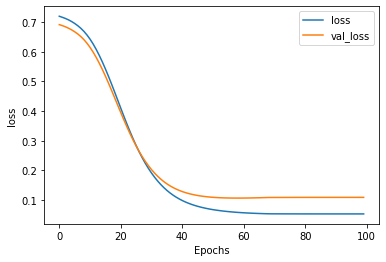

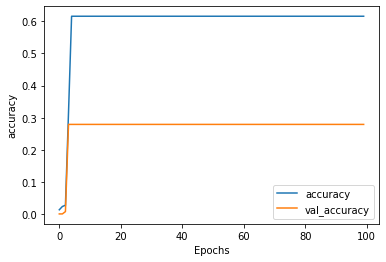

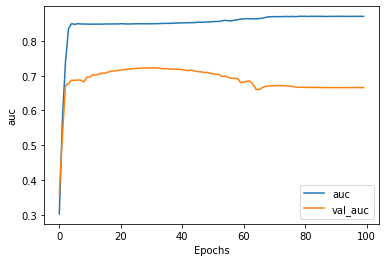

In [234]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig(directory+string+'.png')
    plt.show()

for metric in model.metrics_names:
    plot_graphs(history, metric)

Learning rate -> Coursera Course<br>
[Model architecture](https://ieeexplore.ieee.org/abstract/document/8723320)<br>
[Layer concatenation](https://keras.io/api/layers/merging_layers/concatenate/)<br>
https://stackoverflow.com/questions/38387913/reason-of-having-high-auc-and-low-accuracy-in-a-balanced-dataset